In [1]:
import tropycal.tracks as tracks
from useful_functions import create_genesis_grid_labels
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage.measure as ms
import scipy.ndimage as nd
from itertools import product
import copy

In [2]:
# # Time ranges for EVERYTHING desired
month_range = np.arange(1,13,1).astype(float)
test_years = np.arange(2005,2021,1).astype(float)
train_years = np.arange(1950,2005,1).astype(float)
# train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2).astype(float)
Longitude=np.arange(260,360,2).astype(float)

# Uncomment below section if you want to recreate genesis (observed) labels, otherwise it is already saved

In [3]:
# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")

In [4]:
# Read in Data

train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

# Smoothing the climatology individual years (temporal and spatial!)

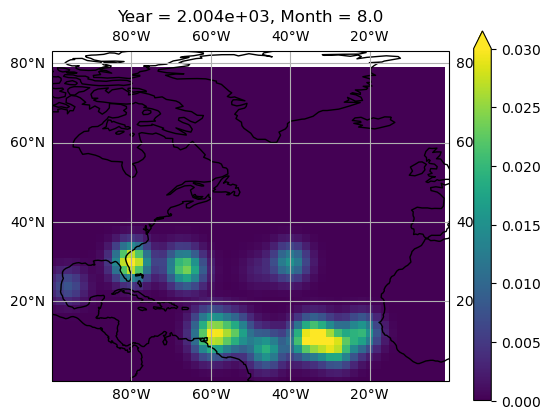

In [5]:
# Deep copy the dataset so it is not referencing
train_canes_use = copy.deepcopy(train_labels_predropped_read["__xarray_dataarray_variable__"]).astype(float)

# Temporal smoothing
for i, j in product(range(train_canes_use.shape[1]),range(train_canes_use.shape[2])): # Loop over each grid cell
    stacked_grid = train_canes_use[:,i,j,:].stack(z=("Year", "Month")).astype(float) # Stack all times for a single grid cell
    temporally_filtered_grid = gaussian_filter(stacked_grid,sigma=1.5) # Filter a single grid cell over time
    unstacked_smoothed_grid = xr.DataArray(temporally_filtered_grid,coords=stacked_grid.coords).unstack() # Put filtered data into XR
    # Assign smoothed grid cell data to training data array
    train_canes_use[:,i,j,:] = copy.deepcopy(unstacked_smoothed_grid.transpose()) # Deep copy the unstacked so that it is not referencing

# Spatial smoothing    
spatially_filtered_grid = [] # List to store the array of each month
stack_for_spatial = train_canes_use.stack(z=("Year", "Month")) # Stack for easier looping

for spatial_iter in range(stack_for_spatial.shape[2]): # Loop 2D array over all times
    spatially_filtered_grid_indiv = gaussian_filter(stack_for_spatial[:,:,spatial_iter],sigma=1.5) # Filter the 2D array spatially
    spatially_filtered_grid.append(spatially_filtered_grid_indiv) # Save 2D array to list

# Convert from list to XR
spatially_temporally_filtered_XR = xr.DataArray(spatially_filtered_grid,coords = [stack_for_spatial.coords['z'],
                                               stack_for_spatial.coords['Latitude'],stack_for_spatial.coords['Longitude']]).unstack()

# Plot temporally then spatially filtered data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=8,Year=2004).plot(vmin=0,vmax=0.03)

# Monthly Temporal Smoothing (Climo)!

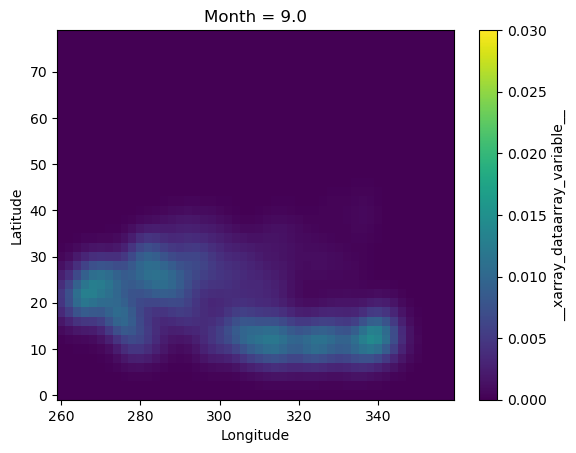

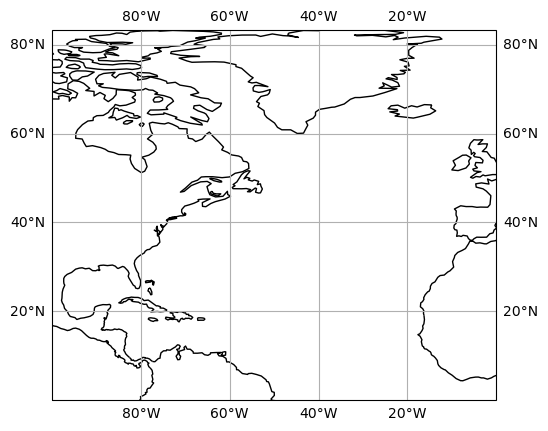

In [6]:
num_years = len(train_labels_predropped_read["Year"]) # Number of Years

# Sum by month, across all years
sum_canes = train_labels_predropped_read.groupby("Month").sum("Year", skipna=True).astype(float)
three_sum_canes = xr.concat([sum_canes,sum_canes,sum_canes],dim="Month").astype(float)

Gauss_SmoothAN = three_sum_canes["__xarray_dataarray_variable__"]/num_years
# Temporal Smoothing
for i, j in product(range(len(Gauss_SmoothAN[0,:,0])),range(len(Gauss_SmoothAN[0,0,:]))): # Loop over all grid cells
    Gauss_SmoothAN[:,i,j] = gaussian_filter(Gauss_SmoothAN[:,i,j], sigma=1.5) # temporal filter

sliced_gauss = Gauss_SmoothAN[len(sum_canes["__xarray_dataarray_variable__"][:,0,0]):
                              len(sum_canes["__xarray_dataarray_variable__"][:,0,0])*2,:,:] # Take only desired section (middle)

# Spatial Smoothing
for loop in range(sliced_gauss.shape[0]):
    sliced_gauss[loop,:,:] = gaussian_filter(sliced_gauss[loop,:,:].astype(float),sigma=1.5) # spatial filter
sliced_gauss.isel(Month=8).plot(vmin=0,vmax=0.03)

# Plot climo data of specified month
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
plt.savefig('climo_double_smoothed.png',dpi=600)